### Modules

In [227]:
import json

import psycopg2 as psyc
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import ttest_ind
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

### ETL

In [236]:
# saved database connection data as a hidden json file, for confidentiality 
with open("/Users/lucasramadan/SCL-Work/.db_conn.json", 'r') as f:
    db_conn = json.load(f)

In [242]:
# create the connection
# unpacking the arguments
conn = psyc.connect(**db_conn)

In [145]:
cur = conn.cursor()

In [152]:
# query to gather metrics 
with open('/Users/lucasramadan/SCL-Work/Travel_Time_Metrics.sql') as f:
    q = f.read()

In [153]:
cur.execute(q)

In [154]:
data = cur.fetchall()

In [155]:
data = np.asarray(data)

In [156]:
data[0]

array([datetime.date(2016, 9, 26), '1-BAY', 28.0299242459463,
       27.5219791703754, 10.8069751170431, 41.5387256088415], dtype=object)

In [211]:
cols = ['market', 'vtt', 'ptt', 'pttpv', 'ttt']

In [158]:
df = pd.DataFrame(data[:, 1:], index=data[:, 0], columns=cols)
df.head()

,market,vtt,ptt,pttpv,ttt
2016-09-26,1-BAY,28.0299,27.522,10.807,41.5387
2016-09-26,2-NY,36.3322,26.2688,11.9568,43.4737
2016-09-26,4-LA,27.1992,32.2527,13.1176,37.8268
2016-09-26,5-CHI,48.9582,42.0592,19.8766,53.1555
2016-09-26,6-DAL,29.8821,31.6354,20.7796,44.1001


### Filtering and Segmentation

In [159]:
logic_change_date = datetime.date(2016, 11, 18)

In [168]:
markets = sorted(list(set(df['market'].values)))
markets

['1-BAY', '2-NY', '4-LA', '5-CHI', '6-DAL', '7-HOU', '8-ATL', '9-MIA']

In [160]:
df = df[df.index < datetime.date.today()]

In [175]:
# making a lookup table for adding to later
location_dfs = {market: {'data': df[df['market'] == market]} for market in markets}

In [179]:
# take a look at one of the market level dfs
location_dfs['1-BAY']['data'].head()

,market,vtt,ptt,pttpv,ttt
2016-09-26,1-BAY,28.0299,27.522,10.807,41.5387
2016-09-27,1-BAY,32.6842,23.7849,11.0652,39.2001
2016-09-28,1-BAY,35.0411,29.6406,15.097,42.0192
2016-09-29,1-BAY,33.1364,28.6504,14.1534,47.8002
2016-09-30,1-BAY,41.199,24.8511,6.23744,44.9069


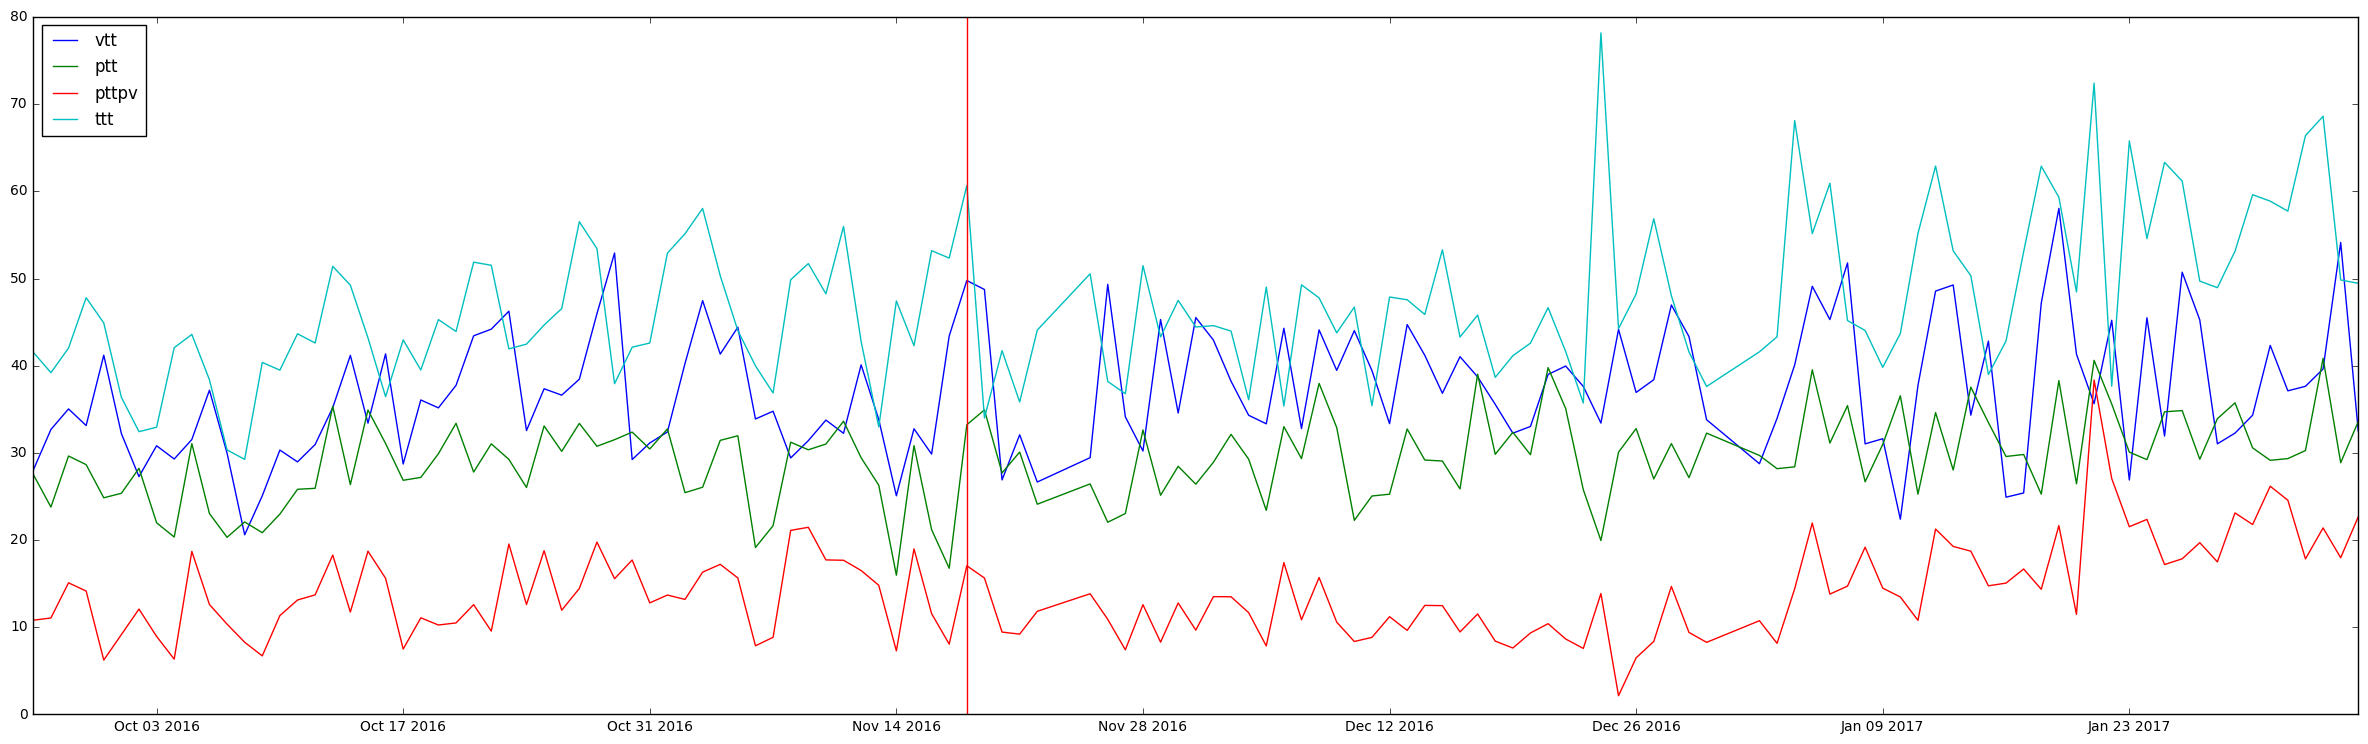

In [180]:
location_dfs['1-BAY']['data'].plot(figsize=(30, 9))
plt.axvline(logic_change_date, c='r')

### Statistical Analysis

In [125]:
logic_change_date

datetime.date(2016, 11, 18)

In [185]:
# calculate before/after data split

for market in location_dfs:
    # before
    before_data = location_dfs[market]['data'][location_dfs[market]['data'].index < logic_change_date]
    location_dfs[market]['before'] = before_data
    
    # after
    after_data = location_dfs[market]['data'][location_dfs[market]['data'].index > logic_change_date]
    location_dfs[market]['after'] = after_data

In [186]:
location_dfs['1-BAY'].keys()

['after', 'data', 'before']

In [190]:
location_dfs['1-BAY']['before'].head()

,market,vtt,ptt,pttpv,ttt
2016-09-26,1-BAY,28.0299,27.522,10.807,41.5387
2016-09-27,1-BAY,32.6842,23.7849,11.0652,39.2001
2016-09-28,1-BAY,35.0411,29.6406,15.097,42.0192
2016-09-29,1-BAY,33.1364,28.6504,14.1534,47.8002
2016-09-30,1-BAY,41.199,24.8511,6.23744,44.9069


In [192]:
for market in location_dfs:
    # alias -- remember to drop market column for calculations below
    before = location_dfs[market]['before']
    before.drop('market', axis=1, inplace=True)
    after = location_dfs[market]['after']
    after.drop('market', axis=1, inplace=True)
    
    # calculate summary stats
    
    before_summary = [np.mean(before[metric].values) for metric in before.columns] 
    after_summary = [np.mean(after[metric].values) for metric in after.columns]

    stats = [ttest_ind(before[metric].values, after[metric].values, usevar='unequal') for metric in before.columns]

    stats = np.asarray(stats).T

    all_values = [before_summary, after_summary] + list(list(s) for s in stats)

    summary = pd.DataFrame(all_values, 
                             columns=before.columns, 
                             index=['before', 'after', 't_score', 'p_value', 'df'])
    
    # finally, save to each market in our lookup
    location_dfs[market]['summary'] = summary

/Users/lucasramadan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lucasramadan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Finally, view the statistical summaries by Market

In [201]:
# simple viewing
for market in markets:
    print market
    print
    print '-'*60
    print location_dfs[market]['summary'].head()
    print '-'*60
    print

1-BAY

------------------------------------------------------------
                vtt         ptt       pttpv         ttt
before    35.050450   27.519538   13.317161   44.237611
after     38.556977   30.546123   14.321541   48.944200
t_score   -2.835857   -3.582139   -1.121953   -3.219270
p_value    0.005359    0.000507    0.264017    0.001635
df       120.937872  110.995567  125.953190  125.976087
------------------------------------------------------------

2-NY

------------------------------------------------------------
                vtt         ptt       pttpv         ttt
before    34.729889   25.844498   14.954225   46.811014
after     31.929721   26.047109   15.502476   45.035452
t_score    2.991670   -0.218086   -0.554112    1.315639
p_value    0.003353    0.827742    0.580716    0.190723
df       122.962044  117.096409  101.929929  123.977272
------------------------------------------------------------

4-LA

------------------------------------------------------------
  

In [207]:
location_dfs['1-BAY']['summary'].ix['t_score']

vtt     -2.835857
ptt     -3.582139
pttpv   -1.121953
ttt     -3.219270
Name: t_score, dtype: float64

In [224]:
# pick out where we had a positive impact

metrics = cols[1:]

for market in markets:
    print market
    print 
    
    t_scores = location_dfs[market]['summary'].ix['t_score']
    p_values = location_dfs[market]['summary'].ix['p_value']
    
    for i, (t_score, p_value) in enumerate(zip(t_scores, p_values)):
        if t_score > 0:
            print '\t', metrics[i]
            print '\t\tt_score:', t_score, 
            print '\t\tp_value:', p_value
    
    print
    print '-'*80

1-BAY


--------------------------------------------------------------------------------
2-NY

	vtt
		t_score: 2.99167008762 		p_value: 0.00335333312815
	ttt
		t_score: 1.31563863978 		p_value: 0.19072311568

--------------------------------------------------------------------------------
4-LA

	ptt
		t_score: 1.69435359898 		p_value: 0.0934491521848

--------------------------------------------------------------------------------
5-CHI


--------------------------------------------------------------------------------
6-DAL

	ptt
		t_score: 1.361667795 		p_value: 0.175771632914

--------------------------------------------------------------------------------
7-HOU

	pttpv
		t_score: 0.158510766884 		p_value: 0.874312438507

--------------------------------------------------------------------------------
8-ATL


--------------------------------------------------------------------------------
9-MIA


--------------------------------------------------------------------------------


In [244]:
# finally close the connection
conn.close()